<a href="https://colab.research.google.com/github/knattarina/wildfire_challenge/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##### IMPORTS AND SETUP #####
#!pip install scikit-learn --upgrade

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, Dropout
from time import time
import os
from google.colab import drive

#from project_lib import Project
#from pyspark.sql import SparkSession

#project = Project(sc,"ff75f9c0-4f85-495d-bbc1-6305f6b1dbb8", "p-12f1b4bbd0ab3b00eacd4ce1201f20ce039b72ec")
#spark = SparkSession.builder.getOrCreate()

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')


df_all = pd.read_csv('Cleansed_Data.csv')
df_all['Date'] = pd.to_datetime(df_all['Date'])

df_all.head()

Mounted at /content/drive


,Date,Region,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,SoilWaterContent_Mean,SoilWaterContent_Min,SoilWaterContent_Variance,SolarRadiation_Max,SolarRadiation_Mean,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance,Month,Year,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea,count()[unit: km^2]
0,2005-01-04,NSW,8.6800,312.2667,42.4000,78.6667,22.8426,2.8086,0.0000,17.3834,90.3328,57.0956,31.2799,267.1584,0.4449,0.2143,0.0226,0.0100,33.2141,22.6173,7.5769,40.2555,28.9455,23.0555,12.4958,9.4555,7.3642,4.8418,1.4020,1.4943,1,2005,6.2000,43.6000,13.0000,0.3000,0.2000,0.2000,0.1000,14.7000,6.8000,0.3000,0.5000,3.7000,10.3000,0.1000,800234.3490
1,2005-01-05,NSW,16.6112,322.4750,62.3625,85.5000,7.6572,0.1579,0.0000,0.2735,88.6234,47.1707,24.4667,195.6397,0.4430,0.2040,0.0199,0.0095,33.5549,28.0768,14.0873,29.7631,29.5101,22.4258,9.6118,13.3524,7.0911,4.0141,1.0113,1.0433,1,2005,6.2000,43.6000,13.0000,0.3000,0.2000,0.2000,0.1000,14.7000,6.8000,0.3000,0.5000,3.7000,10.3000,0.1000,800234.3490
2,2005-01-06,NSW,5.5200,325.2667,38.4000,78.3333,27.6165,0.4348,0.0000,4.6345,92.8510,39.8746,21.7060,213.3006,0.4319,0.1937,0.0200,0.0088,34.0758,30.5617,12.3105,22.6677,26.9827,20.6214,9.0240,11.7642,9.9058,4.4779,0.9308,1.9537,1,2005,6.2000,43.6000,13.0000,0.3000,0.2000,0.2000,0.1000,14.7000,6.8000,0.3000,0.5000,3.7000,10.3000,0.1000,800234.3490
3,2005-01-07,NSW,6.2640,313.8700,33.8000,92.2000,3.8392,0.0642,0.0000,0.0389,79.1031,39.2794,16.2155,245.6246,0.4185,0.1838,0.0181,0.0078,34.0192,32.1437,16.0446,6.9493,24.7521,19.6327,8.6912,7.9404,10.4468,4.0176,1.6017,1.1028,1,2005,6.2000,43.6000,13.0000,0.3000,0.2000,0.2000,0.1000,14.7000,6.8000,0.3000,0.5000,3.7000,10.3000,0.1000,800234.3490
4,2005-01-08,NSW,5.4000,337.3833,122.5333,91.0000,2.8667,0.2034,0.0000,0.2363,83.0015,42.4008,14.0085,342.9968,0.4134,0.1759,0.0144,0.0075,33.2651,29.3477,15.2099,27.8228,26.4725,21.4773,10.8213,12.0640,6.6719,3.8846,1.1679,0.7746,1,2005,6.2000,43.6000,13.0000,0.3000,0.2000,0.2000,0.1000,14.7000,6.8000,0.3000,0.5000,3.7000,10.3000,0.1000,800234.3490


In [4]:
columns = ['Region', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',	'Mean_confidence']

df = df_all[df_all['Region'] == 'QL'].copy()
df['Quarter'] = df['Date'].apply(lambda x: x.quarter)
df.drop(columns = columns, inplace = True)

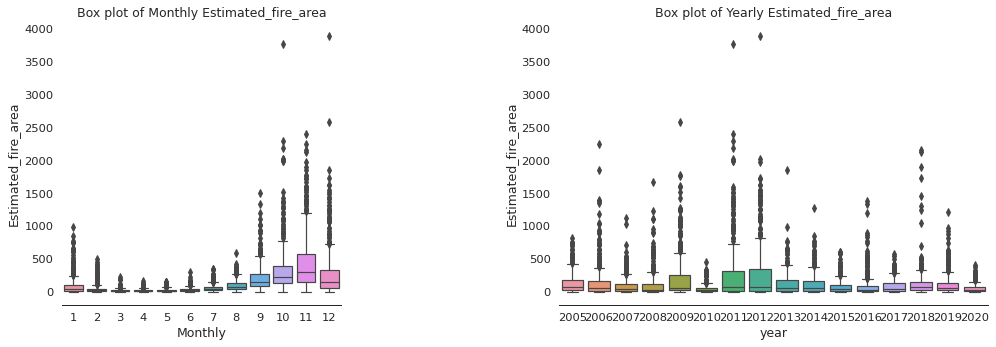

In [5]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="Year", y="Estimated_fire_area", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Estimated_fire_area')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,1)
sns.boxplot(x="Quarter", y="Estimated_fire_area", data=df)
plt.xlabel('Quarter')
plt.title('Box plot of Quarterly Estimated_fire_area')
sns.despine(left=True)
plt.tight_layout();

plt.subplot(1,3,1)
sns.boxplot(x="Month", y="Estimated_fire_area", data=df)
plt.xlabel('Monthly')
plt.title('Box plot of Monthly Estimated_fire_area')
sns.despine(left=True)
plt.tight_layout();

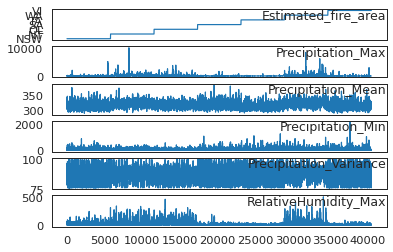

In [12]:
import matplotlib.pyplot as pyplot

values = df_all.values
# specify columns to plot
groups = np.arange(1, df.shape[1]-37)
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [48]:
columns = ['Region', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',	'Mean_confidence']

df = df_all[df_all['Region'] == 'QL'].copy()
df.drop(columns = columns, inplace = True)

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df.drop(['Date', 'Estimated_fire_area'], axis = 1).values)
df_scaled

array([[0.15947381, 0.06532726, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18801255, 0.06944341, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11915847, 0.14870733, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02300721, 0.00342764, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02130348, 0.00591412, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05647456, 0.01738997, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [53]:
# having the dataset as x and y . Making x into a 3-d data and y as 2-d data ie.) reshaping
X_train = []
y_train = []
n_output_steps = 28  # Number of outputs we want to predict into the future
n_input_steps = 30   # Number of past inputs that we want to use to predict the future
for i in range(n_input_steps, len(df_scaled) - n_output_steps +1):
    X_train.append(df_scaled[i - n_input_steps:i, 0:df.shape[1] - 1])
    y_train.append(df_scaled[i + n_output_steps - 1:i + n_output_steps, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape == {}.'.format(X_train.shape))   # no.of samples, no. of time stamps, no. of features
print('y_train shape == {}.'.format(y_train.shape))   # no. of features, no. of output time steps

X_train shape == (5726, 30, 42).
y_train shape == (5726, 1).


In [57]:
# creating the lstm model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input_steps, X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))             # since we need the prediction of these many stocks
model.compile(optimizer='adam', loss='mse')

In [58]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=20)

Epoch 1/100
229/229 [==============================] - 16s 56ms/step - loss: 0.0040 - val_loss: 0.0031

Epoch 00001: val_loss improved from inf to 0.00311, saving model to weights.h5
Epoch 2/100
229/229 [==============================] - 11s 49ms/step - loss: 0.0033 - val_loss: 0.0021

Epoch 00002: val_loss improved from 0.00311 to 0.00208, saving model to weights.h5
Epoch 3/100
229/229 [==============================] - 11s 49ms/step - loss: 0.0026 - val_loss: 0.0020

Epoch 00003: val_loss improved from 0.00208 to 0.00200, saving model to weights.h5
Epoch 4/100
229/229 [==============================] - 11s 49ms/step - loss: 0.0023 - val_loss: 0.0023

Epoch 00004: val_loss did not improve from 0.00200
Epoch 5/100
229/229 [==============================] - 11s 49ms/step - loss: 0.0018 - val_loss: 0.0019

Epoch 00005: val_loss improved from 0.00200 to 0.00190, saving model to weights.h5
Epoch 6/100
229/229 [==============================] - 11s 49ms/step - loss: 0.0024 - val_loss: 0.002

In [59]:
predictions_future = model.predict(X_train[-n_output_steps:])
predictions_train = model.predict(X_train[n_input_steps:])

In [60]:
print(predictions_train.shape)
predictions_train

(5696, 1)


array([[0.00917744],
       [0.009296  ],
       [0.00934493],
       ...,
       [0.05634171],
       [0.0556409 ],
       [0.05696013]], dtype=float32)

In [61]:
predictions_future.shape

(28, 1)

In [62]:
y_pred = pd.DataFrame(predictions_future)
y_pred = y_pred.T            
#y_pred = y_pred.loc[0:2414]
y_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.0466,0.0474,0.0485,0.0493,0.0488,0.0493,0.0499,0.0506,0.0513,0.0517,0.0515,0.0486,0.0451,0.0426,0.0425,0.0435,0.0455,0.0473,0.0482,0.0490,0.0513,0.0538,0.0559,0.0575,0.0569,0.0563,0.0556,0.0570


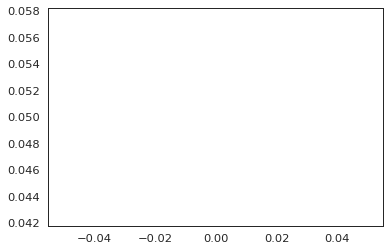